In [1]:
import os
import glob
from pathlib import Path
import polars as pl
import re
import gzip
import sys
import random
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from lxml import etree, objectify
from rapidfuzz import fuzz
from spacy import displacy

import infineac.file_loader as file_loader
import infineac.helper as helper
import infineac.process_event as process_event
import infineac.topic_extractor as topic_extractor
import infineac.process_text as process_text

%load_ext autoreload
%autoreload 2

PATH_DIR = "../data/transcripts/"
random.seed(111)

/Users/Foal/miniconda3/envs/infineac/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/Foal/miniconda3/envs/infineac/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/Foal/miniconda3/envs/infineac/lib/python3.10/site-packages/

## Load NLP model

In [2]:
import spacy_stanza
nlp_stanza = spacy_stanza.load_pipeline("en", processors="tokenize, lemma")
nlp_stanza.add_pipe('sentencizer')

2023-09-07 09:51:51 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-09-07 09:51:54 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| lemma     | combined |

2023-09-07 09:51:54 WARNING: GPU requested, but is not available!
2023-09-07 09:51:54 INFO: Using device: cpu
2023-09-07 09:51:54 INFO: Loading: tokenize
2023-09-07 09:51:54 INFO: Loading: lemma
2023-09-07 09:51:54 INFO: Done loading processors!


## Load Files

Load all xml files from the given directory and return a list of corresponding events.

In [18]:
# files = [Path("../data/transcripts/2022/15203138_T.xml")]
files = list(Path(PATH_DIR).rglob("*.xml"))
events = file_loader.load_files_from_xml(files)

Files: 100%|██████████| 500/500 [00:01<00:00, 369.97it/s]


Check if all positions are valid

In [4]:
process_event.test_positions(events)

## Filter data

Filter out all events that are not in the given time range and do not include the given keywords.

In [19]:
events_filt_all = process_event.filter_events(events, year = 2022, keywords = {"russia":1, "ukraine":1}, modifier_words=[])
events_filt = process_event.filter_events(events, year = 2022, keywords = {"russia":1, "ukraine":1})
len(events_filt)

Filtering events


Events: 100%|██████████| 500/500 [00:00<00:00, 1087.98it/s]


Filtering events


Events: 100%|██████████| 500/500 [00:02<00:00, 232.11it/s]


118

In [6]:
helper.save_data(events_filt, "events_filt", compression="lz4")

List all events, that are filtered out due to modifier words preceding the keywords.

In [8]:
events_filtered_filter_words = []
ids_filtered_events = []
for i, event in enumerate(events_filt):
    ids_filtered_events.append(event['id'])
for event in events_filt_all:
    if event['id'] not in ids_filtered_events:
        events_filtered_filter_words.append(event)
print(len(events_filtered_filter_words))
process_event.extract_passages_from_events(events_filtered_filter_words, keywords=["russia", "ukraine"], modifier_words=[], nlp_model=nlp_stanza)

6
Extracting paragraphs from events


Events: 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]


[[[[[' In addition, there will still be significant opportunity for expansion beyond this as these 70-plus countries represent less than 60% of broadband homes globally, excluding Russia and China.']]],
  []],
 [[],
  [[[' Now we finally have begun that journey with the Finaro acquisition, and there will be others in order to support what I think is one of the best justifications for international expansion possible, which is the subscription billing sexy tech platform that has opportunities literally in every part of the world, except Russia and China.']]]],
 [[],
  [[['So you see that there is no change on our guidance either for H1, 6% to 8%, excluding Russia, of full year. We confirm the 6% to 8% growth, excluding Russia.']],
   [['And the performance of the division was 7% like-for-like, excluding Russia.']]]],
 [[[['European growth would have been 7% on a year-to-date basis in local currency, excluding Russia.']]],
  []],
 [[[['International revenues were up 11% or 14% excluding 

## Exploration

In [9]:
file = [event['file'] for event in events_filt]
id = [event['id'] for event in events_filt]
year_upload = [event['year_upload'] for event in events_filt]
company = [event['company_name'] for event in events_filt]
ticker = [event['company_ticker'] for event in events_filt]
ticker_new = [re.sub('\\..*', '', t) for t in ticker]
dates = [event['date'] for event in events_filt if "date" in event.keys()]
numeric_values = mdates.date2num(dates)

russia_and_sanction = [process_text.get_russia_and_sanction(event['qa_collapsed'] + event['presentation_collapsed']) for event in events_filt]
election = [process_text.get_elections(event['qa_collapsed'] + event['presentation_collapsed']) for event in events_filt]
russia_count = [str(event['qa_collapsed'] + event['presentation_collapsed']).lower().count('russia') for event in events_filt]
sanction_count = [str(event['qa_collapsed'] + event['presentation_collapsed']).lower().count('sanction') for event in events_filt]

Create a DataFrame with the following columns:

In [10]:
df = pd.DataFrame({'file': file,
                   'year_upload': year_upload,
                   'company': company,
                   'ticker':ticker,
                   'ticker_new': ticker_new,
                   'date': dates,
                   'dates_num' : numeric_values,
                   'russia': russia_and_sanction,
                   'russia_count': russia_count,
                   'sanction_count': sanction_count,
                   'election': election})

Count the number of occasions where the word "russia" (and "sanction") appears in the earnings call.

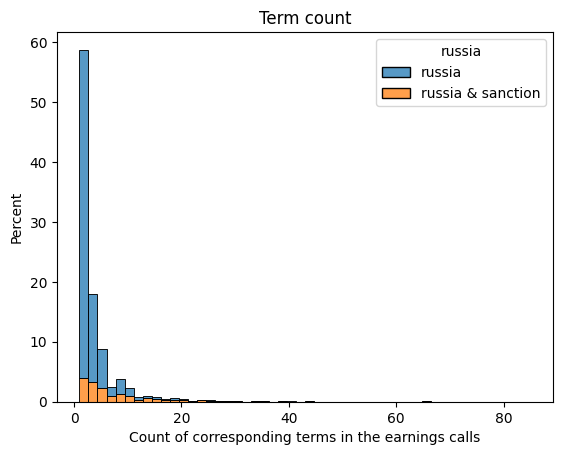

In [11]:
sns.histplot(df[df['russia_count']>=1], x='russia_count', hue="russia", bins=50, stat="percent", common_norm=True, multiple="stack")
plt.xlabel('Count of corresponding terms in the earnings calls')
plt.ylabel('Percent')
plt.title('Term count')
plt.show()

Average mentions of "russia" per earnings call.

In [12]:
np.array(russia_count).mean()

2.7451327433628316

Average mentions of "russia" per earnings call if "russia" is mentioned at
least once.

In [13]:
np.array([el for el in russia_count if el > 0]).mean()

3.8724289620734753

Average mentions of "sanction" per earnings call.

In [14]:
np.array([el for el in sanction_count if el > 0]).mean()

2.4227877385772123

Event distribution over time highlighting the different categories.

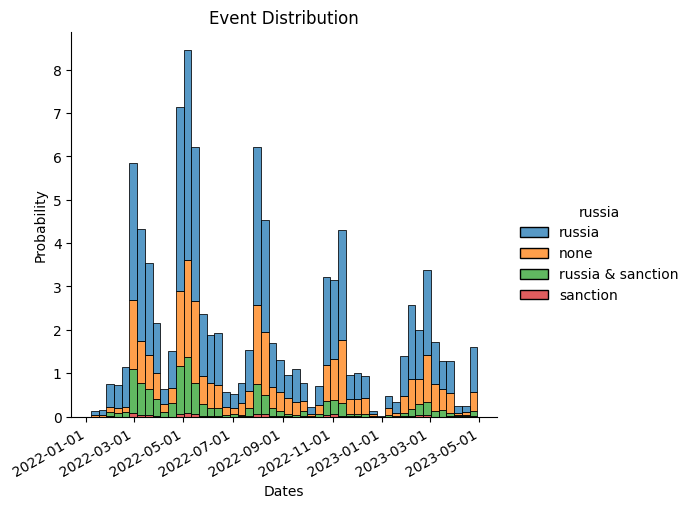

In [15]:
# plt.hist(numeric_values, bins=50)
# sns.histplot(numeric_values, bins=50)
sns.displot(df, x="dates_num", hue="russia", bins=50, stat="percent", common_norm=True, multiple="stack")
# plt.plot_date(dates, numeric_values, '-o')  # '-o' adds markers on the data points
plt.xlabel('Dates')
plt.ylabel('Probability')
plt.title('Event Distribution')

# Add x-axis ticks and labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Customize date format as needed

plt.gcf().autofmt_xdate()  # Adjusts the date labels rotation for better visibility

plt.show()

Event proportion over time highlighting the different categories.

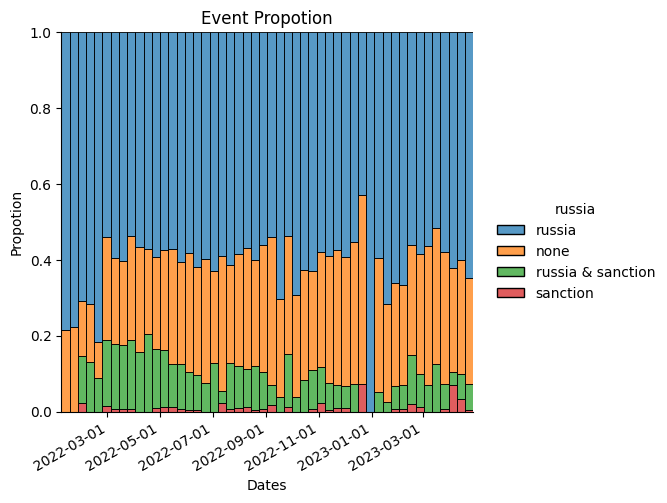

In [16]:
# plt.hist(numeric_values, bins=50)
# sns.histplot(numeric_values, bins=50)
sns.displot(df, x="dates_num", hue="russia", bins=50, stat="proportion", common_norm=True, multiple="fill")
# plt.plot_date(dates, numeric_values, '-o')  # '-o' adds markers on the data points
plt.xlabel('Dates')
plt.ylabel('Propotion')
plt.title('Event Propotion')

# Add x-axis ticks and labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Customize date format as needed

plt.gcf().autofmt_xdate()  # Adjusts the date labels rotation for better visibility

plt.show()

## Preprocess and extract corpus

In [4]:
events_filt = helper.load_data("events_filt.lz4")

Create different types of corpora:
1. Corpus with a window of 1 sentence and not joining adjacent sentences.
2. Corpus with a window of 1 sentence and joining adjacent sentences.
3. Corpus with a window of 3 sentences and joining adjacent sentences.
4. Corpus with a window of 5 sentences and joining adjacent sentences.
5. Corpus with a window that includes the whole paragraph from the keywords on.

In [172]:
corpus_window_0_df = process_event.events_to_corpus(
    events=events_filt,
    keywords={"russia": 1, "ukraine": 1},
    context_window_sentence=0,
    subsequent_paragraphs=0,
    join_adjacent_sentences=False,
    extract_answers=False,
    nlp_model=nlp_stanza,
    remove_additional_words=True,
)
len(corpus_window_0_df)

Extracting passages from events


Events: 100%|██████████| 11865/11865 [24:49<00:00,  7.97it/s] 


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 45126/45126 [14:04<00:00, 53.45it/s] 


45126

In [156]:
corpus_window_0_join_df = process_event.events_to_corpus(
    events=events_filt,
    keywords={"russia": 1, "ukraine": 1},
    context_window_sentence=0,
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=False,
    nlp_model=nlp_stanza,
    remove_additional_words=True,
)
len(corpus_window_0_join_df)

Extracting passages from events


Events: 100%|██████████| 11865/11865 [26:53<00:00,  7.35it/s] 


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 39217/39217 [12:27<00:00, 52.45it/s] 


39217

In [173]:
corpus_window_3_join_df = process_event.events_to_corpus(
    events=events_filt,
    keywords={"russia": 1, "ukraine": 1},
    context_window_sentence=[0,3],
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=False,
    nlp_model=nlp_stanza,
    remove_additional_words=True,
)
len(corpus_window_3_join_df)

Extracting passages from events


Events: 100%|██████████| 11865/11865 [25:40<00:00,  7.70it/s] 


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 36099/36099 [17:48<00:00, 33.80it/s] 


36099

In [174]:
corpus_window_5_join_df = process_event.events_to_corpus(
    events=events_filt,
    keywords={"russia": 1, "ukraine": 1},
    context_window_sentence=[0,5],
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=False,
    nlp_model=nlp_stanza,
    remove_additional_words=True,
)
len(corpus_window_5_join_df)

Extracting passages from events


Events: 100%|██████████| 11865/11865 [26:31<00:00,  7.46it/s] 


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 35752/35752 [17:56<00:00, 33.20it/s]


35752

In [175]:
corpus_window_whole_join_df = process_event.events_to_corpus(
    events=events_filt,
    keywords={"russia": 1, "ukraine": 1},
    context_window_sentence=[0,-1],
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=False,
    nlp_model=nlp_stanza,
    remove_additional_words=True,
)
len(corpus_window_whole_join_df)

Extracting passages from events


Events: 100%|██████████| 11865/11865 [26:06<00:00,  7.57it/s] 


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 35848/35848 [21:00<00:00, 28.45it/s] 


35848

Save and load data

In [176]:
helper.save_data(corpus_window_0_df, "corpus_window_0_df_no_answer", compression="lz4")
helper.save_data(corpus_window_0_join_df, "corpus_window_0_join_df_no_answer", compression="lz4")
helper.save_data(corpus_window_3_join_df, "corpus_window_3_join_df_no_answer", compression="lz4")
helper.save_data(corpus_window_5_join_df, "corpus_window_5_join_df_no_answer", compression="lz4")
helper.save_data(corpus_window_whole_join_df, "corpus_window_whole_join_df_no_answer", compression="lz4")

In [3]:
corpus_window_0_df = helper.load_data("corpus_window_0_df_no_answer.lz4")
corpus_window_0_join_df = helper.load_data("corpus_window_0_join_df_no_answer.lz4")
corpus_window_3_join_df = helper.load_data("corpus_window_3_join_df_no_answer.lz4")
corpus_window_5_join_df = helper.load_data("corpus_window_5_join_df_no_answer.lz4")
corpus_window_whole_join_df = helper.load_data("corpus_window_whole_join_df_no_answer.lz4")

## Extract Strategies

In [7]:
corpus_window_3_join_df = process_text.get_strategies(dataframe=corpus_window_3_join_df)
corpus_window_3_join_df.groupby('id').agg(pl.col('exit_strategy', 'stay_strategy', 'adaptation_strategy').sum(), pl.col('text', 'processed_text')).sort('id')

id,exit_strategy,stay_strategy,adaptation_strategy,text,processed_text
i64,u32,u32,u32,list[str],list[str]
5402278,0,0,0,"[""Thank you to our teams who have selected, who have looked for talent, thank you to those teams because thanks to them, we have hired over 500 refugees coming from the Ukraine in 22 countries, and they are now part of the Inditex family."", ""And this despite the fact that we took the decision to provision EUR 216 million in order to cover those expenses, which would result, we believe, that's a consequence of our activities in Russia and Ukraine."", … ""We are ofcoarse in ongoing touch with our teams in Russia and in Ukraine, it's over 10,000 employees between the 2 countries. We continue to support them. We continue to reach out to them. Of course, there are different interest groups that are affected by the situation.""]","[""thank team select look talent thank team thanks hire refugee come country inditex family"", ""despite fact take decision provision eur million order cover expense result believe consequence activity"", … ""ofcoarse ongoing touch team 10000 employee country continue support continue reach course different interest group affect situation""]"
5413503,0,0,0,"[""Poland has done really very well when you think that it sits next door to Ukraine and given what's been happening in Ukraine. It's taken an influx of 2.4 million refugees from Ukraine."", ""They've become part of the Polish working force these refugees ought really almost seamlessly and trading companies from Ukraine have also relocated to Poland. And naturally, there's been an influx of capital into Poland on the back of NATO extra NATO spend in the region as well as to help Poland with the effects of the Ukrainian war. So the war, if you like, for Poland has not been an adverse economic event. And part of the buoyancy of the Polish economy stems back to that.""]","[""poland think sit door give happen take influx 2.4 million refugee"", ""polish work force refugee ought seamlessly trading company relocate poland naturally influx capital poland nato extra nato spend region help poland effect ukrainian war war like poland adverse economic event buoyancy polish economy stem""]"
5489134,0,0,0,"[""This, combined with the geopolitics around us not relying on China and Russia for our metals, will bode well for the future of the mining industry.""]","[""combine geopolitics rely china metal bode future mining industry""]"
5565265,0,0,0,"[""How this will ultimately impact longer-term demand for North American oil is uncertain."", ""The circumstances surrounding the current military conflict in the Ukraine are both troubling and unpredictable. The situation has caused governments to reconsider the geographic sources of their oil and gas supplies.""]","[""ultimately impact long term demand north american oil uncertain"", ""circumstance surround current military conflict troubling unpredictable situation cause government reconsider geographic source oil gas supplies""]"
5654917,0,0,0,"[""In addition to the climate crisis, the main challenge of our time, the pandemic, the progressive deglobalization, increasing poverty, the democratic -- demographic challenge, complex polarization of society's disinformation and digital security, we now face the terrible consequences of the war in Ukraine."", ""During this time, the union has worked hard with one main objective, that is to armor itself against the Russian's energy dictatorship. This effort has materialized in the REPowerEU plan, which is a firm commitment to a massive and much more accelerated deployment of renewable energies on energy efficiency and diversification of suppliers. With this plan, the European Union will say goodbye to dependence on fossil fuels, consequences of which the exorbitant prices are being felt by households and businesses across Europe."", ""Globally, 2021 has been a year marked by increasing volatility and complexity, compounded by a series of events that have adde

In [59]:
sum(corpus_window_0_df['exit_strategy'])

1449

### Analyse corpus

In [31]:
lengths = [len(doc) for doc in corpus_window_0_df['processed_text'].to_list()]
np.argmax(np.array(lengths))

4893

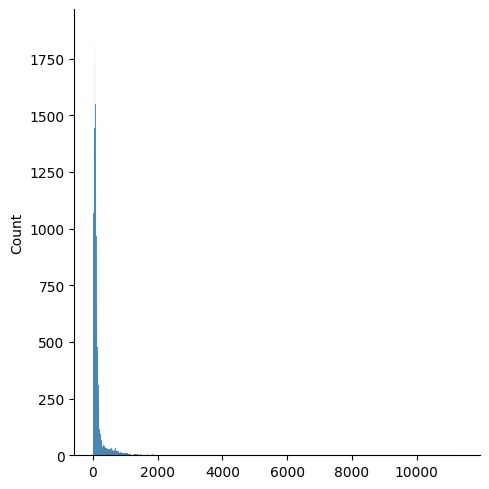

In [32]:
sns.displot(np.array(lengths))

## Extract topics

In [9]:
remove_additionl_words = ["this", "that"]
if remove_additionl_words is True:
    print("yes")
else: print("no")

no


In [4]:
from bertopic.representation import KeyBERTInspired
from bertopic.representation import PartOfSpeech
from bertopic.representation import MaximalMarginalRelevance
from transformers import pipeline
from bertopic.representation import TextGeneration
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer

# vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words="english", min_df=10)


# main_representation = KeyBERTInspired()
inspired_model = KeyBERTInspired()

# sentence model
# sentence_model = SentenceTransformer("all-mpnet-base-v2")
sentence_model_light = SentenceTransformer("all-MiniLM-L6-v2")

# mmr model
mmr_model = MaximalMarginalRelevance(diversity=0.4)

# pos model
nlp_stanza_pos = spacy_stanza.load_pipeline("en", processors="tokenize, pos")
pos_model = PartOfSpeech(nlp_stanza_pos)

# Create a generator model
prompt = "I have a topic described by the following keywords: [KEYWORDS]. Based on the previous keywords, what is this topic about?"
generator = pipeline('text2text-generation', model='google/flan-t5-base')
generator_model = TextGeneration(generator)

# chain models
chain_model_1 = [inspired_model, mmr_model]
chain_model_2 = [inspired_model, mmr_model, pos_model]
# chain_model_3 = [inspired_model, pos_model, mmr_model]
generator_chain_model_1 = [inspired_model, mmr_model, generator_model]
# generator_chain_model_2 = [inspired_model, mmr_model, pos_model, generator_model]


# Add all models together to be run in a single `fit`
representation_model = {
   "Main": inspired_model,
   # "Pos":  pos_model,
   "Chain: Inspired - MMR":  chain_model_1,
   "Chain: Inspired - MMR - POS":  chain_model_2,
   # "Chain: Inspired - POS - MMR":  chain_model_3,
   # "Generator": generator_model,
   "Generator chain: Inspired - MMR": generator_chain_model_1,
   # "Generator chain: Inspired - MMR - POS": generator_chain_model_2
}

2023-09-07 09:53:16 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-09-07 09:53:17 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |

2023-09-07 09:53:17 WARNING: GPU requested, but is not available!
2023-09-07 09:53:17 INFO: Using device: cpu
2023-09-07 09:53:17 INFO: Loading: tokenize
2023-09-07 09:53:17 INFO: Loading: pos
2023-09-07 09:53:18 INFO: Done loading processors!


1.
* Sentence window: 0
* No join

In [15]:
topic_model_0, topics_0, probs_0 = topic_extractor.bert_advanced(corpus_window_0_df['processed_text'].to_list(), representation_model=representation_model, embedding_model=sentence_model_light)

Batches:   0%|          | 0/1411 [00:00<?, ?it/s]

2023-09-04 13:09:25,373 - BERTopic - Transformed documents to Embeddings
2023-09-04 13:10:06,270 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-09-04 13:16:38,424 - BERTopic - Clustered reduced embeddings
100%|██████████| 427/427 [02:59<00:00,  2.38it/s]


In [18]:
topic_model_0.get_topic_info()

,Topic,Count,Name,Representation,Chain: Inspired - MMR,Chain: Inspired - MMR - POS,Generator chain: Inspired - MMR,Representative_Docs
0,-1,22377,-1_inflation_headwind_demand_economy,"[inflation, headwind, demand, economy, market,...","[inflation, headwind, demand, economy, market,...","[year, quarter, business, impact, war, market,...","[covid pandemic, , , , , , , , , ]",[good news feel like headwind pandemic lot cha...
1,0,773,0_belarus_belarusian_kazakhstan_moldova,"[belarus, belarusian, kazakhstan, moldova, cou...","[belarus, belarusian, kazakhstan, moldova, cou...","[belarusian, shipment, talent, activity, regio...","[belarusian company moldova, , , , , , , , , ]","[year go belarus, business belarus, belarus]"
2,1,772,1_energy_renewable_electricity_efficiency,"[energy, renewable, electricity, efficiency, d...","[energy, renewable, electricity, efficiency, d...","[energy, security, transition, electricity, re...","[renewable energy, , , , , , , , , ]",[obviously happen increase need energy securit...
3,2,553,2_logistics_supplier_supply_inventory,"[logistics, supplier, supply, inventory, sourc...","[logistics, supplier, supply, inventory, sourc...","[chain, supply, disruption, constraint, invent...","[logistics of production, , , , , , , , , ]","[mention supply chain, u.k. war event see disr..."
4,3,418,3_coal_market_gas_demand,"[coal, market, gas, demand, coking, supply, an...","[coal, market, gas, demand, coking, supply, an...","[coal, thermal, coking, pci, ban, import, buye...","[coal tar, , , , , , , , , ]","[country continue coal, coal market, coal market]"
...,...,...,...,...,...,...,...,...
422,421,10,421_export_exporting_exporter_europe,"[export, exporting, exporter, europe, european...","[export, exporting, exporter, europe, european...","[gnp, export, paper, memory, quote, unlikely, ...","[exporting to europe, , , , , , , , , ]",[absolutely right paper export anymore europea...
423,422,10,422_war_question_ask_think,"[war, question, ask, think, we, point, positio...","[war, question, ask, think, we, point, positio...","[coloplast, question, matt, happy, point, turn...","[coloplast, , , , , , , , , ]","[second question war, question war think we'd ..."
424,423,10,423_gas_market_shortage_supply,"[gas, market, shortage, supply, price, cost, u...","[gas, market, shortage, supply, price, cost, u...","[gas, price, cut, european, usd, flow, bottlen...","[gas price in the european union, , , , , , , ...",[scenario course critical cut gas import price...
425,424,10,424_energy_food_economy_risk,"[energy, food, economy, risk, crisis, geopolit...","[energy, food, economy, risk, crisis, geopolit...","[food, unjustified, downside, disconnect, comm...","[food crisis, , , , , , , , , ]",[think see difficult disconnect economy west c...


In [43]:
hierarchical_topics = topic_model_0.hierarchical_topics(corpus_window_0_df['processed_text'].to_list())

100%|██████████| 425/425 [01:41<00:00,  4.21it/s]


Hierarchische Gliederung der Themen

In [46]:
topic_model_0.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

2.
* Sentence window: 0
* Join sentences

In [17]:
topic_model_0_join, topics_0_join, probs_0_join = topic_extractor.bert_advanced(corpus_window_0_join_df['processed_text'].to_list(), representation_model=representation_model, embedding_model=sentence_model_light)

Batches:   0%|          | 0/1226 [00:00<?, ?it/s]

2023-09-04 13:46:31,496 - BERTopic - Transformed documents to Embeddings
2023-09-04 13:46:51,379 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-09-04 13:51:25,827 - BERTopic - Clustered reduced embeddings
100%|██████████| 359/359 [02:33<00:00,  2.35it/s]


In [20]:
topic_model_0_join.get_topic_info()

,Topic,Count,Name,Representation,Chain: Inspired - MMR,Chain: Inspired - MMR - POS,Generator chain: Inspired - MMR,Representative_Docs
0,-1,20314,-1_inflation_demand_economy_economic,"[inflation, demand, economy, economic, crisis,...","[inflation, demand, economy, economic, crisis,...","[market, war, gas, business, impact, energy, q...","[inflation and market volatility, , , , , , , ...",[mean know war lot uncertainty come especially...
1,0,790,0_belarus_belarusian_kazakhstan_moldova,"[belarus, belarusian, kazakhstan, moldova, cou...","[belarus, belarusian, kazakhstan, moldova, cou...","[belarus, belarusian, revenue, shipment, talen...",[belarusian kazakhstan and moldova are the cou...,"[year go belarus, 2.5 sale belarus, belarus ma..."
2,1,765,1_supplier_supply_logistics_inventory,"[supplier, supply, logistics, inventory, sourc...","[supplier, supply, logistics, inventory, sourc...","[chain, supply, supplier, disruption, inventor...","[sourcing, , , , , , , , , ]","[war war pressure supply chain, clearly war di..."
3,2,371,2_invasion_invade_attack_violence,"[invasion, invade, attack, violence, aggressiv...","[invasion, invade, attack, violence, aggressiv...","[invasion, invade, day, course, start, morning...","[afghanistan invasion, , , , , , , , , ]","[impact situation invasion, invasion, invasion]"
4,3,366,3_coal_demand_market_gas,"[coal, demand, market, gas, pricing, supply, e...","[coal, demand, market, gas, pricing, supply, e...","[coal, thermal, coking, ban, meet, import, ton...","[coal and coking, , , , , , , , , ]",[europe need replace coal volume result price ...
...,...,...,...,...,...,...,...,...
354,353,10,353_healthcare_medical_clinical_hospital,"[healthcare, medical, clinical, hospital, pati...","[healthcare, medical, clinical, hospital, pati...","[patient, clinical, continuity, care, surgery,...",[enrolment in healthcare services for patients...,[healthcare business sector overall clinical s...
355,354,10,354_kiev_ukrainian_relocate_shortage,"[kiev, ukrainian, relocate, shortage, territor...","[kiev, ukrainian, relocate, shortage, territor...","[demographical, ukrainian, bleak, mobilization...","[ukraine ukraine ukraine ukraine ukrain, , , ,...","[actually new new helicopter kiev, kiev, fortu..."
356,355,10,355_stay_leave_continue_long,"[stay, leave, continue, long, say, course, opt...","[stay, leave, continue, long, say, course, opt...","[stay, option, decision, question, course, , ,...",[i want to stay on course if i want to confirm...,"[stay, oh yes yes leave, oh yes yes leave]"
357,356,10,356_capacity_monopoly_limited_production,"[capacity, monopoly, limited, production, euro...","[capacity, monopoly, limited, production, euro...","[capacity, monopoly, cann, malt, optical, outs...","[monopoly of european market, , , , , , , , , ]",[italy get capability produce optical componen...


In [38]:
corpus_window_0_join_df_company = corpus_window_0_join_df.with_columns(pl.Series('topics', topics_0_join)).groupby('id').agg(pl.col('topics','text', 'processed_text')).sort('id')
topics = list(corpus_window_0_join_df_company['topics'])

In [42]:
set_list = []
for i,topic in enumerate(topics):
    set_list.append(list(set(topic)))

In [40]:
set_list

[[82, 20, -1],
 [-1],
 [-1],
 [-1],
 [35, -1],
 [0, -1],
 [45, -1],
 [-1],
 [72, 9, -1],
 [-1],
 [0, 26, -1],
 [-1],
 [193, 6, 7, 8, 11, 12, 13, 114, 275, 117, 215, 122, 157, -1],
 [72, 9, -1],
 [82, -1],
 [78, 85, -1, 41],
 [288, -1, 167],
 [128, 102, 41, 170, 27, 28, -1],
 [32, -1],
 [-1],
 [-1],
 [25, 11, 12, -1],
 [91, 190],
 [-1],
 [96, 20, -1],
 [34, -1],
 [27, 45],
 [-1],
 [46, -1],
 [123, 45, 15],
 [106, -1, 23],
 [24, -1],
 [1, -1],
 [-1],
 [-1],
 [0, 209, 45, -1],
 [312, -1, 151],
 [-1, 63],
 [1, 9, 109, 48, 80, 117, 309, 89, 124, -1],
 [49, 50, 19, 20, -1],
 [291, -1, 30],
 [291],
 [320, 2, 12, 209, -1],
 [-1],
 [2, 167, 40, 41, 143, 343, -1, 63],
 [148, 46],
 [62, 102, 111],
 [90],
 [90],
 [-1],
 [78],
 [102, 236, 148, 343, 26, -1],
 [156, -1],
 [123, 12, -1],
 [152, -1],
 [322, 67, 38, 138, 45, 16, 145, 28, -1],
 [322, 4, 170, 21, 312, -1],
 [-1],
 [298],
 [-1],
 [-1],
 [101, 38, 103, 39, 170, 303, 20, 21, -1],
 [9, 138, 53, -1],
 [9, 11, 21, -1],
 [0, 262, 109, 82, 51, 28

Reduced to 50 topics

In [22]:
topic_model_0_join_50, topics_0_join_50, probs_0_join_50 = topic_extractor.bert_advanced(corpus_window_0_join_df['processed_text'].to_list(), representation_model=representation_model, embedding_model=sentence_model_light, nr_topics=50)

Batches:   0%|          | 0/1226 [00:00<?, ?it/s]

2023-09-04 14:15:38,930 - BERTopic - Transformed documents to Embeddings
2023-09-04 14:15:59,230 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-09-04 14:19:35,767 - BERTopic - Clustered reduced embeddings
100%|██████████| 50/50 [00:28<00:00,  1.78it/s]
2023-09-04 14:37:13,247 - BERTopic - Reduced number of topics from 356 to 50


In [23]:
topic_model_0_join_50.get_topic_info()

,Topic,Count,Name,Representation,Chain: Inspired - MMR,Chain: Inspired - MMR - POS,Generator chain: Inspired - MMR,Representative_Docs
0,-1,20552,-1_impact_economic_demand_effect,"[impact, economic, demand, effect, inflation, ...","[impact, economic, demand, effect, inflation, ...","[war, impact, year, business, market, quarter,...","[economics, , , , , , , , , ]",[ongoing event include covid mitigation effort...
1,0,6643,0_inflation_demand_war_shortage,"[inflation, demand, war, shortage, supply, gas...","[inflation, demand, war, shortage, supply, gas...","[supply, gas, war, chain, inflation, price, ma...","[oil, , , , , , , , , ]",[concerned ongoing global logistics constraint...
2,1,3037,1_earnings_revenue_million_billion,"[earnings, revenue, million, billion, investme...","[earnings, revenue, million, billion, investme...","[business, exposure, eur, impairment, revenue,...","[ebitda, , , , , , , , , ]","[talk net exposure eur million, combination co..."
3,2,1602,2_war_military_conflict_peace,"[war, military, conflict, peace, crisis, invas...","[war, military, conflict, peace, crisis, invas...","[war, conflict, geopolitical, people, uncertai...","[war, conflict, peace, business, , , , , , , ,...","[war, war, war]"
4,3,1402,3_belarus_belarusian_kazakhstan_poland,"[belarus, belarusian, kazakhstan, poland, ukra...","[belarus, belarusian, kazakhstan, poland, ukra...","[ukrainian, business, country, people, belarus...","[belarus, , , , , , , , , ]","[belarus material, year go belarus, belarus]"
5,4,567,4_invasion_invade_attack_war,"[invasion, invade, attack, war, warfare, impac...","[invasion, invade, attack, war, warfare, impac...","[invasion, defense, drone, cyber, invade, atta...","[invasion of iraq, , , , , , , , , ]","[impact invasion business, invasion, year inva..."
6,5,531,5_patient_clinical_trial_hospital,"[patient, clinical, trial, hospital, fda, medi...","[patient, clinical, trial, hospital, fda, medi...","[patient, trial, humanitarian, support, study,...",[fda - a clinical trial of a drug called a ste...,"[look patient patient, development start new c..."
7,6,479,6_export_exporting_exporter_import,"[export, exporting, exporter, import, ship, sh...","[export, exporting, exporter, import, ship, sh...","[export, port, import, shipment, sea, ship, ca...","[import & export of cargo from port, , , , , ,...","[export, export, export]"
8,7,412,7_impact_impacting_effect_damage,"[impact, impacting, effect, damage, hit, invas...","[impact, impacting, effect, damage, hit, invas...","[impact, omicron, quarter, easter, q1, damage,...","[impact of hurricane katrina, , , , , , , , , ]","[impact, ahead pre-covid number summer recover..."
9,8,412,8_employee_colleague_employ_payroll,"[employee, colleague, employ, payroll, office,...","[employee, colleague, employ, payroll, office,...","[employee, colleague, family, safety, people, ...",[employee of a company employing a colleague o...,"[employee, employee business consequence emplo..."


3.
* Sentence window: 3
* Join sentences  

In [21]:
topic_model_3_join, topics_3_join, probs_3_join = topic_extractor.bert_advanced(corpus_window_3_join_df['processed_text'].to_list(), representation_model=representation_model, embedding_model=sentence_model_light)

TypeError: bert_inspired() missing 1 required positional argument: 'representation_model'

In [21]:
topic_model_3_join.get_topic_info().to_csv("topic_model_3_join.csv")

4.
* Sentence window: 5
* Join sentences


In [14]:
topic_model_5_join, topics_5_join, probs_5_join = topic_extractor.bert_inspired(corpus_window_5_join_df['processed_text'].to_list())

Batches:   0%|          | 0/1208 [00:00<?, ?it/s]

2023-08-31 15:06:31,375 - BERTopic - Transformed documents to Embeddings
2023-08-31 15:06:51,024 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-08-31 15:09:00,223 - BERTopic - Clustered reduced embeddings


In [24]:
topic_model_5_join.get_topic_info().to_csv("topic_model_5_join.csv")

5.
* Sentence window: whole paragraph
* Join sentences

In [15]:
topic_model_whole_join, topics_whole_join, probs_whole_join = topic_extractor.bert_inspired(corpus_window_whole_join_df['processed_text'].to_list())

Batches:   0%|          | 0/1215 [00:00<?, ?it/s]

2023-08-31 15:15:23,146 - BERTopic - Transformed documents to Embeddings
2023-08-31 15:15:42,651 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-08-31 15:17:37,673 - BERTopic - Clustered reduced embeddings


In [25]:
topic_model_whole_join.get_topic_info().to_csv("topic_model_whole_join.csv")

38868

In [356]:
probs[1]

array([0.02466603, 0.032443  , 0.0426969 , 0.02744634, 0.02321597,
       0.0192848 , 0.0492035 , 0.01937474, 0.04401463, 0.04043768,
       0.04437236, 0.02610516, 0.02285282, 0.02287447, 0.0305101 ])

In [49]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,19059,-1_inflation_crisis_pandemic_economic,"[inflation, crisis, pandemic, economic, demand...",[market forecast market base current visibilit...
1,0,4650,0_demand_market_business_guidance,"[demand, market, business, guidance, portfolio...",[yes typically provide update midway quarter o...
2,1,820,1_refugee_humanitarian_charity_donation,"[refugee, humanitarian, charity, donation, uni...","[support people refugee, support refugee emplo..."
3,2,660,2_belarus_belarusian_kazakhstan_russian,"[belarus, belarusian, kazakhstan, russian, cou...","[sale belarus, year go belarus, belarus]"
4,3,535,3_wheat_corn_agriculture_agricultural,"[wheat, corn, agriculture, agricultural, grain...","[corn wheat come big way, know difficulty asso..."
...,...,...,...,...,...
301,300,10,300_revenue_growth_year_offset,"[revenue, growth, year, offset, contractual, t...",[emea year year growth quarter negatively affe...
302,301,10,301_freight_turnover_rail_railway,"[freight, turnover, rail, railway, railroad, t...",[look month year freight rail turnover overall...
303,302,10,302_expect_expectation_demand_profitability,"[expect, expectation, demand, profitability, f...",[yes start contract manufacturing know get gen...
304,303,10,303_decline_maintenance_service_growth,"[decline, maintenance, service, growth, offsho...",[service growth america menac strong oil gas o...


In [358]:
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model.approximate_distribution(corpus_window_0_join_df['processed_text'].to_list(), calculate_tokens=True)

100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


In [359]:
len(topic_distr)

933

In [363]:
topic_distr[1]

array([0.27688306, 0.        , 0.        , 0.        , 0.15484435,
       0.15860631, 0.32902648, 0.        , 0.        , 0.08063981,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [361]:
# topic distribution of a certain document
topic_model.visualize_distribution(topic_distr[1])

In [365]:
# Visualize the token-level distributions
df = topic_model.visualize_approximate_distribution(corpus_window_0_join_df['processed_text'].to_list()[1], topic_token_distr[1])
df

,conversely,get,europe,north,america,look,geopolitical,risk,particularly,associate,go,look,maybe,derisk,global,basis,move,little,bit,close,headquarters,operation
0_demand_production_industry_market,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.106,0.235,0.365,0.365,0.259,0.130,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4_macroeconomic_inflation_inflationary_economy,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.102,0.102,0.102,0.204,0.102,0.102,0.102,0.000,0.000,0.000,0.000
5_revenue_business_profit_investment,0.000,0.000,0.000,0.000,0.000,0.000,0.101,0.209,0.209,0.209,0.108,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6_energy_demand_heating_war,0.000,0.115,0.223,0.223,0.223,0.108,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.105,0.211,0.211,0.211,0.106,0.000,0.000
9_grain_foodtech_harvest_soybean,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.106,0.106,0.106,0.106,0.000,0.000


In [372]:
# values for individual topics
topic_model.get_topic(1)

[('refinery', 0.48095948),
 ('refiner', 0.4155772),
 ('import', 0.4111076),
 ('oil', 0.3860207),
 ('europe', 0.3736658),
 ('diesel', 0.36351082),
 ('fuel', 0.35027352),
 ('eu', 0.3479474),
 ('supply', 0.34047055),
 ('russian', 0.33826613)]

In [ ]:
from sentence_transformers.cross_encoder import CrossEncoder

In [ ]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('paraphrase-distilroberta-base-v1')
sentence1 = "Now this slide talks more about the immediate impact where the combination of sanctions and also business destruction in Ukraine leads or may lead to supply chain disruptions."
sentence2 = "We obviously intensively evaluate all the potential impacts, created a task force that meets almost daily to follow on these topics and basically do preventive measures as to limit the potential impact on CEZ."

doc1 = nlp(sentence1)
doc2 = nlp(sentence2)
similarity = doc1.similarity(doc2)

sentences_ = [sentence1, sentence2]
sentence_embeddings = model.encode(sentences_)

print("Cosine Similarity: " + str(util.pytorch_cos_sim(sentence_embeddings[0], sentence_embeddings[1]).item()))
print("similiarity: " + str(similarity))

In [ ]:
# import dill as pickle
# pickle.dump(events_russia, open('../output/pickled/events_russia.pkl', 'wb'))
# pickle.dump(events, open('../output/pickled/events.pkl', 'wb'))

In [ ]:
docs = [event['presentation_collapsed'] + "\n" + event['qa_collapsed'] for event in events_russia]

In [ ]:
df.to_csv('../output/data/overview.csv', index=False)

In [ ]:
#  df[['company', 'ticker', 'ticker_new', 'date', 'russia', 'russia_count', 'sanction_count']].to_csv('../output/data/overview_jakob.csv', index=False)
# with open('../output/data/overview_jakob.csv', 'rb') as f_in:
#     with gzip.open('../output/data/overview_jakob.csv.gz', 'wb') as f_out:
#         shutil.copyfileobj(f_in, f_out)

Create 15 samples for each category: russia and election and save it in the
corresponding directory.

In [ ]:
if len(df[df['russia'] == 'russia & sanctions']) >0:sample_files_russia = df[df['russia'] == 'russia'].sample(8)['file'].tolist() + df[df['russia'] == 'russia & sanctions'].sample(7)['file'].tolist()
if len(df[df['election'] == 'presidential election']) >0: sample_files_election = df[df['election'] == 'presidential election'].sample(15)['file'].tolist()

In [ ]:
# delete all files in folder
if 'sample_files_russia' in locals() or 'sample_files_russia' in globals():
    folder = '../output/sample transcripts/russia/'
    files = os.listdir(folder)
    for f in files:
        os.remove(folder + f)
    # copy sample files to folder
    for file in sample_files_russia:
        shutil.copy(file, folder)

In [ ]:
# delete all files in folder
if 'sample_files_election' in locals() or sample_files_election in globals():
    folder = '../output/sample transcripts/election/'
    files = os.listdir(folder)
    for f in files:
        os.remove(folder + f)
    # copy sample files to folder
    for file in sample_files_election:
        shutil.copy(file, folder)

Polars

In [ ]:
keys_to_keep = ['file', 'body_orig']

In [ ]:
events_new_trimmed = [{key: event[key] for key in keys_to_keep} for event in events_new]

In [ ]:
eventsDF = pl.from_dicts(events_new_trimmed)

In [ ]:
eventsDF = eventsDF.with_columns(pl.col("body_orig").str.count_match('(E|e)lections').alias("elections_count"))
eventsDF = eventsDF.with_columns(pl.col("body_orig").str.count_match('(S|s)anctions').alias("sanctions_count"))
eventsDF = eventsDF.with_columns(pl.col("body_orig").str.count_match('(R|r)ussia').alias("russia_count"))

In [ ]:
len(eventsDF.filter(pl.col("elections_count") > 0))

In [ ]:
len(eventsDF.filter((pl.col("sanctions_count") > 0) & (pl.col("russia_count") > 0)))